# Baselines

## Import Dependencies

In [1]:
#import dependencies
! pip install tensorboardX
! pip install numpy-quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json
import math
import xgboost as xg


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

ModuleNotFoundError: No module named 'torch'

In [3]:
import argparse
args = argparse.Namespace()

#Paths to different files
args.root_dir = '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handheld'
args.train_list = osp.join(args.root_dir, 'Train.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.test_list = osp.join(args.root_dir, 'Test.txt')
args.out_dir = osp.join(args.root_dir, 'outputs')
args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')


args.test_path = None
args.cache_path = None
args.continue_from = None
args.transfer_from = None


# Params to tune for neural network
args.mode = "train"
args.step_size = 10
args.window_size = 200
args.lr = 1e-04
args.batch_size = 256
args.epochs = 80
args.freeze_params = False

# miscallaneous
args.arch = "resnet18"
args.cpu = False
args.run_ekf = False
args.fast_test = False

# Plots and animation
args.show_plot = True
args.saveAnim = True

# Smoothing feature and targets
args.feature_sigma = 2
args.target_sigma = 2

np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

In [10]:
def get_dataset(root_dir, data_list, args, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    if mode == 'train':
        random_shift = args.step_size // 2
        shuffle = True
        transforms = RandomHoriRotate(math.pi * 2)
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    seq_type = OxfordGlobSpeedSequence
    dataset = StridedSequenceDataset(seq_type, root_dir, data_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
                                     grv_only=grv_only, transforms = transforms, random_shift = random_shift)
    print(f'step_size: {dataset.step_size}, window_size: {dataset.window_size}')
    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)    

In [11]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int32) # Gets an array of frame IDs which correspond to the sequence
    #dts = 0.01
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])

    pos = np.zeros([preds.shape[0] + 2, 2])
    # initial position using first position value
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    
    # the intermediate positions using the time interval and adding to initial position
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    
    # This does interpolation because we do not have positions for every timestep. [ts[0] +/- 1e-06] corresponds to the end with an additional small value
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    # print(f'pos shape final: {pos}')
    return pos

In [12]:
def showAnimation(video_path):
    import ipywidgets as widgets
    from IPython.display import display
    video_widget = widgets.Video.from_file(video_path)
    video_widget.controls = True
    video_widget.autoplay = True
    display(video_widget)

def plotTrajectory(true_x_values, true_y_values, pred_x_values, pred_y_values):    
    plt.figure('{}'.format("Trajectory"), figsize=(16, 9))

    length = len(true_x_values)
    multiplier = 50
    # creating a blank window
    # for the animation
    fig = plt.figure()
    min_x_value = np.min([np.min(true_x_values), np.min(pred_x_values)])
    max_x_value = np.max([np.max(true_x_values), np.max(pred_x_values)])
    min_y_value = np.min([np.min(true_y_values), np.min(pred_y_values)])
    max_y_value = np.max([np.max(true_y_values), np.max(pred_y_values)])
    
    
    axis = plt.axes(xlim =(min_x_value, max_x_value), ylim =(min_y_value, max_y_value))
    
    line1, = axis.plot([], [], 'b', label='Line 1')
    line2, = axis.plot([], [], 'r', label='Line 2')

    def init():
        line1.set_data([], [])
        return line1,
    def init():
        line2.set_data([], [])
        return line2,

    # initializing empty values
    # for x and y co-ordinates
    true_xdata, true_ydata, pred_xdata, pred_ydata = [], [], [], []

    # animation function
    def animate(i):
        true_x = true_x_values[i * multiplier]
        true_y = true_y_values[i * multiplier]
        pred_x = pred_x_values[i * multiplier]
        pred_y = pred_y_values[i * multiplier]
        
        true_xdata.append(true_x)
        true_ydata.append(true_y)
        pred_xdata.append(pred_x)
        pred_ydata.append(pred_y)
        
        line1.set_data(true_xdata, true_ydata)
        line2.set_data(pred_xdata, pred_ydata)

        return line1, line2

    # calling the animation function	
    anim = animation.FuncAnimation(fig, animate, init_func = init, frames = int(length/multiplier), interval = 0.01, blit = True)
    return anim

## XGBoost

In [36]:
# Loading data
X_train, y_train = [], []

start_t = time.time()
train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='train')
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

for batch_id, (feat, targ, _, _) in enumerate(train_loader):
    X_train.append(feat)
    y_train.append(targ)

X_train = torch.cat(X_train, dim=0).numpy()
y_train = torch.cat(y_train, dim=0).numpy()
print(X_train.shape)
print(y_train.shape)
end_t = time.time()
print('Training set loaded. Feature size: {}, target size: {}. Time usage: {:.3f}s'.format(
    train_dataset.feature_dim, train_dataset.target_dim, end_t - start_t))


xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)
#xgb_r.fit(train_X, train_y)

step_size: 10, window_size: 200
(50184, 6, 200)
(50184, 2)
Training set loaded. Feature size: 6, target size: 2. Time usage: 9.125s


In [37]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')  # You can try different kernels (linear, polynomial, rbf)
svr.fit(X_train, y_train)


ValueError: Found array with dim 3. SVR expected <= 2.

## Naive Double Integration (Assuming correct orientations)

In [40]:
! pip install numpy-quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [41]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [42]:
def get_dataset(root_dir, data_list):
    
    sequence = OxfordGlobSpeedSequence(osp.join(root_dir, data_list))
    return sequence.features, sequence.targets, sequence.gt_pos


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list)    

In [75]:
feat, targ, gt_pos = get_dataset('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1', 'combined3.csv')
acc_data = feat[:,3:]

In [76]:
gt_pos.shape

(57999, 3)

In [77]:
targ.shape

(57998, 2)

In [78]:
acc_data.shape

(57998, 3)

In [79]:
# Initial conditions
initial_position = [0, 0, 0]  # Initial position [x, y, z]
initial_velocity = [0, 0, 0]  # Initial velocity [x_dot, y_dot, z_dot]
trajectory = [[0], [0], [0]]
velocity_traj = [[0], [0], [0]]

# Variables for current state
position = initial_position.copy()
velocity = initial_velocity.copy()

# Variables for previous state
prev_timestamp = 0.0
prev_acceleration = [0, 0, 0]  # Previous acceleration [x, y, z]


In [80]:
for acceleration in acc_data:
    # Calculate time difference
    dt = 0.01

    # Double integration for position
    position[0] += velocity[0] * dt + 0.5 * acceleration[0] * dt**2
    position[1] += velocity[1] * dt + 0.5 * acceleration[1] * dt**2
    position[2] += velocity[2] * dt + 0.5 * acceleration[2] * dt**2
    trajectory[0].append(position[0])
    trajectory[1].append(position[1])
    trajectory[2].append(position[2])

    # Update velocity
    velocity[0] += acceleration[0] * dt
    velocity[1] += acceleration[1] * dt
    velocity[2] += acceleration[2] * dt
    velocity_traj[0].append(velocity[0])
    velocity_traj[1].append(velocity[1])
    velocity_traj[2].append(velocity[2])

    # Store current values as previous values for the next iteration
    prev_acceleration = acceleration.copy()


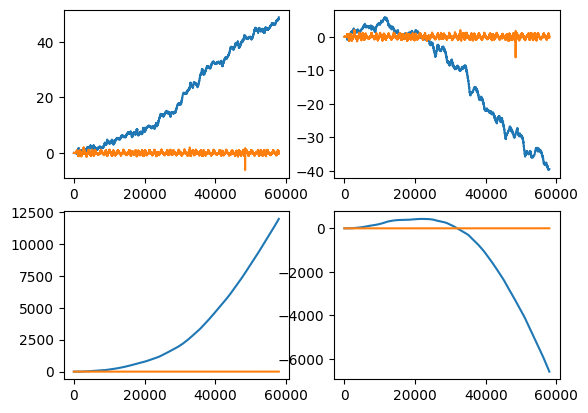

In [81]:
plt.subplot(2,2,1)
plt.plot(velocity_traj[0])
plt.plot(targ[:,0])

plt.subplot(2,2,2)
plt.plot(velocity_traj[1])
plt.plot(targ[:,0])

plt.subplot(2,2,3)
plt.plot(trajectory[0])
plt.plot(gt_pos[:,0])

plt.subplot(2,2,4)
plt.plot(trajectory[1])
plt.plot(gt_pos[:,0])

## Pedestrian Dead Reckoning

In [1]:
import argparse
import json
import os
import sys
from os import path as osp

import h5py
import matplotlib.pyplot as plt
import numpy as np
import quaternion
from scipy.interpolate import interp1d

#if want to search for packages from the parent file
#sys.path.append(osp.join(osp.dirname(osp.abspath(__file__)), '..'))

from math_util import *
from metric import compute_absolute_trajectory_error, compute_relative_trajectory_error



All done. Average ate:nan, average rte: nan


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
args = argparse.Namespace()
args.list = None
args.root_dir = None
args.align_length = 600
args.path = None
args.stride = 0.67
args.out_dir = None
args.show_plot = False





In [ ]:
root_dir, data_list = '', []
if args.path is not None:
    if args.path[-1] == '/':
        args.path = args.path[:-1]
    root_dir = osp.split(args.path)[0]
    data_list = [osp.split(args.path)[1]]
elif args.list is not None:
    root_dir = args.root_dir
    with open(args.list) as f:
        data_list = [s.strip().split()[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']

if args.out_dir is not None and not osp.isdir(args.out_dir):
    os.makedirs(args.out_dir)

ate_all, rte_all = [], []
pred_per_min = 200 * 60

for data in data_list:
    data_path = osp.join(root_dir, data)
    with open(osp.join(data_path, 'info.json')) as f:
        info = json.load(f)
        device = info['device']
        rot_imu_to_tango = quaternion.quaternion(*info['start_calibration'])
        ref_time_imu = info['imu_reference_time']
        imu_time_offset = info['imu_time_offset']
        start_frame = info.get('start_frame', 0)

    with h5py.File(osp.join(data_path, 'data.hdf5')) as f:
        ori = np.copy(f['synced/game_rv'])
        tango_ori_q = quaternion.from_float_array(f['pose/tango_ori'])
        ori_q = quaternion.from_float_array(ori)
        init_rotor = tango_ori_q[0] * rot_imu_to_tango * ori_q[0].conj()
        ori = quaternion.as_float_array(init_rotor * ori_q)[start_frame:]

        ts = np.copy(f['synced/time'])[start_frame:]
        tango_pos = np.copy(f['pose/tango_pos'])[start_frame:]
        step = np.copy(f['raw/imu/step'])

    step_ts = step[:, 0] / 1e09 - imu_time_offset
    sid, eid = 0, step_ts.shape[0] - 1
    while sid < step_ts.shape[0] and ts[0] > step_ts[sid]:
        sid += 1
    while eid >= 0 and ts[-1] < step_ts[eid]:
        eid -= 1
    assert sid < step_ts.shape[0] and eid >= 0

    step_ts = step_ts[sid:eid + 1]
    step = step[sid:eid + 1]

    ori_at_step = interpolate_quaternion_linear(ori, ts, step_ts)
    yaw_at_step = orientation_to_angles(ori_at_step)[:, 0]

    rot_hori = np.stack([np.cos(yaw_at_step), np.sin(yaw_at_step),
                         -np.sin(yaw_at_step), np.cos(yaw_at_step)], axis=1).reshape([-1, 2, 2])
    step_v = np.stack([np.zeros(step.shape[0]), np.ones(step.shape[0]) * args.stride], axis=1)

    step_glob = np.squeeze(np.matmul(rot_hori, np.expand_dims(step_v, axis=2)), axis=2)
    pos_pred = np.zeros([step_glob.shape[0] + 1, 2])
    step_ts = np.concatenate([[ts[0]], step_ts], axis=0)
    pos_pred[0] = tango_pos[0][:2]
    pos_pred[1:] = np.cumsum(step_glob, axis=0) + pos_pred[0]

    eid = ts.shape[0] - 1
    while eid >= 0 and ts[eid] > step_ts[-1]:
        eid -= 1
    pos_gt = tango_pos[:eid + 1, :2]
    pos_pred = interp1d(step_ts, pos_pred, axis=0)(ts[:eid + 1])

    if args.align_length is not None and args.align_length > 0:
        _, r, t = icp_fit_transformation(pos_pred[:args.align_length], pos_gt[:args.align_length])
        pos_pred = np.matmul(r, pos_pred.T).T + t

    # For trajectories shorted than 1 min, we scale the RTE value accordingly.
    if pos_pred.shape[0] < pred_per_min:
        ratio = pred_per_min / pos_pred.shape[0]
        rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pos_pred.shape[0] - 1) * ratio
    else:
        rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pred_per_min)
    rte_all.append(rte)

    ate = compute_absolute_trajectory_error(pos_pred, pos_gt)
    ate_all.append(ate)
    print('Sequence {}, ate {:.6f}, rte {:.6f}'.format(data, ate, rte))

    plt.close('all')
    plt.figure(data, figsize=(8, 6))
    plt.plot(pos_gt[:, 0], pos_gt[:, 1])
    plt.plot(pos_pred[:, 0], pos_pred[:, 1])
    plt.legend(['Ground truth', 'Estimated'])
    plt.axis('equal')
    plt.tight_layout()

    if args.out_dir is not None and osp.isdir(args.out_dir):
        plt.savefig(osp.join(args.out_dir, data + '_pdr.png'))

    if args.show_plot:
        plt.show()

print('All done. Average ate:{:.6f}, average rte: {:.6f}'.format(np.mean(ate_all), np.mean(rte_all)))
if args.out_dir is not None and osp.isdir(args.out_dir):
    with open(osp.join(args.out_dir, 'result.csv'), 'w') as f:
        f.write('seq,ate,rte\n')
        for i in range(len(data_list)):
            f.write('{},{:.6f},{:.6f}\n'.format(data_list[i], ate_all[i], rte_all[i]))